In [30]:
# Imports

import torch

import numpy as np
import gymnasium as gym
from collections import deque
import pygame
import random
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [94]:
# DQN model which takes in the state as an input and outputs predicted q values for every possible action
class DQN(torch.nn.Module):
    def __init__(self, state_space, action_space):
        super().__init__()
        # Add your architecture parameters here
        # You can use nn.Functional
        # Remember that the input is of size batch_size x state_space
        # and the output is of size batch_size x action_space (ulta ho sakta hai dekh lo)
        # TODO: Add code here
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(np.prod(state_space), 256)
        # self.fc2 = torch.nn.Linear(256, 128)
        self.fc4 = torch.nn.Linear(256, action_space)

    def forward(self, input):
        # TODO: Complete based on your implementation
        x = self.flatten(input)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        output = self.fc4(x)
        return output


In [ ]:

import torch.nn as nn


class SnakeDQN(nn.Module):
    def __init__(self, grid_shape=(10, 10), action_dim=4):
 
        super(SnakeDQN, self).__init__()
        self.input_channels = 1
        self.grid_shape = grid_shape  
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * grid_shape[0] * grid_shape[1], 512)
        self.fc2 = nn.Linear(512, action_dim)

    def forward(self, x):
        x = x.unsqueeze(1) 
        x = x / 255.0 
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [90]:
# While training neural networks, we split the data into batches.
# To improve the training, we need to remove the "correlation" between game states
# The buffer starts storing states and once it reaches maximum capacity, it replaces
# states at random which reduces the correlation.
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)


In [95]:
# TODO: Implement training logic for CartPole environment here
# Remember to use the ExperienceBuffer and a target network
# Details can be found in the book sent in the group


batch_size = 64
learning_rate = 0.001
gamma = 0.99
sync_freq = 100
epsilon = 1.000
losses = []
epochs = 520
replay_buffer = ExperienceBuffer(10000)  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make('CartPole-v1')
obs_dim = env.observation_space.shape

action_dim = env.action_space.n

policy_net = DQN(obs_dim, action_dim).to(DEVICE)
target_net = DQN(obs_dim, action_dim).to(DEVICE)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)
state, _ = env.reset()
loss = torch.tensor(0.0)
for _ in range(1000):
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        replay_buffer.push(np.array(state, dtype=np.float32), action, reward, np.array(next_state, dtype=np.float32), done)

        state = next_state if not done else env.reset()[0]

i = 0
rewards = []
for j in range(epochs):
        state, _ = env.reset()
        episode_reward = 0
        status = 1
        while (status == 1):
                i += 1
                if random.random() < epsilon : 
                        action = env.action_space.sample()
                else:
                        state_tensor = torch.tensor([state], dtype = torch.float32).to(DEVICE)
                        q_vals = policy_net(state_tensor)
                        action = q_vals.max(1)[1].item()
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                replay_buffer.push(np.array(state, dtype=np.float32), action, reward, np.array(next_state, dtype=np.float32), done)

                state = next_state
                episode_reward += reward
                if len(replay_buffer) < batch_size:
                        continue

                transitions = replay_buffer.sample(batch_size)
                states, actions, rewards_batch, next_states, dones = transitions
                states = torch.tensor(np.stack(states), dtype=torch.float32, device=DEVICE)
                actions = torch.tensor(actions, dtype=torch.int64, device=DEVICE).unsqueeze(1)
                rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32, device=DEVICE).unsqueeze(1)
                next_states = torch.tensor(np.stack(next_states), dtype=torch.float32, device=DEVICE)
                dones = torch.tensor(dones, dtype=torch.float32, device=DEVICE).unsqueeze(1)

             
                q_values = policy_net(states).gather(1, actions)

        
                with torch.no_grad():
                    max_next_q = target_net(next_states).max(1)[0].unsqueeze(1)
                    target_q = rewards_batch + gamma * max_next_q * (1 - dones)


                loss = torch.nn.MSELoss()(q_values, target_q)

       
                optimizer.zero_grad()
                loss.backward()
                
                optimizer.step()

                if (i % sync_freq == 0):
                       target_net.load_state_dict(policy_net.state_dict())

                if done : 
                       rewards.append(episode_reward)
                       print(f"Episode {j} - Reward: {episode_reward:.2f}  Loss: {loss:.4f}  Epsilon: {epsilon:.3f}")
                       status = 2
                        
        if epsilon > 0.1:
               epsilon -= 0.009/5
        






Episode 0 - Reward: 94.00  Loss: 0.0082  Epsilon: 1.000
Episode 1 - Reward: 15.00  Loss: 0.5099  Epsilon: 0.998
Episode 2 - Reward: 17.00  Loss: 0.3246  Epsilon: 0.996
Episode 3 - Reward: 39.00  Loss: 0.1200  Epsilon: 0.995
Episode 4 - Reward: 22.00  Loss: 0.0591  Epsilon: 0.993
Episode 5 - Reward: 13.00  Loss: 0.0092  Epsilon: 0.991
Episode 6 - Reward: 19.00  Loss: 0.4364  Epsilon: 0.989
Episode 7 - Reward: 12.00  Loss: 0.1367  Epsilon: 0.987
Episode 8 - Reward: 26.00  Loss: 0.1333  Epsilon: 0.986
Episode 9 - Reward: 22.00  Loss: 0.3406  Epsilon: 0.984
Episode 10 - Reward: 27.00  Loss: 0.6179  Epsilon: 0.982
Episode 11 - Reward: 18.00  Loss: 0.0247  Epsilon: 0.980
Episode 12 - Reward: 11.00  Loss: 0.2840  Epsilon: 0.978
Episode 13 - Reward: 34.00  Loss: 0.1038  Epsilon: 0.977
Episode 14 - Reward: 10.00  Loss: 0.0696  Epsilon: 0.975
Episode 15 - Reward: 14.00  Loss: 0.1823  Epsilon: 0.973
Episode 16 - Reward: 23.00  Loss: 0.7775  Epsilon: 0.971
Episode 17 - Reward: 18.00  Loss: 0.3524 

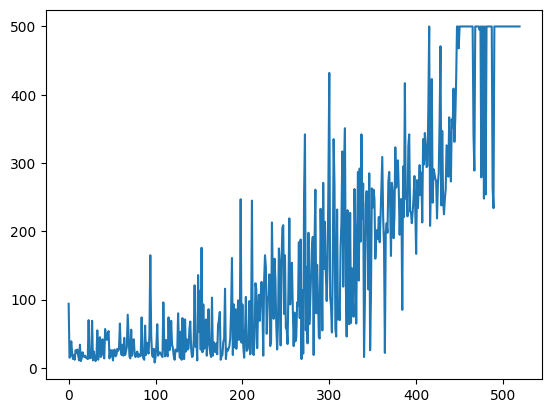

In [96]:
plt.plot(rewards)

In [97]:
def evaluate_cartpole_model(model, episodes=10, render=True):
    env = gym.make("CartPole-v1", render_mode="human" if render else None)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    model.eval()

    rewards = []

    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = model(state)
                action = torch.argmax(q_values, dim=1).item()

            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            total_reward += reward

            if render:
                env.render()

        rewards.append(total_reward)
        print(f"Episode {episode + 1}: Reward = {total_reward}")

    env.close()
    avg_reward = sum(rewards) / episodes
    print(f"Average reward over {episodes} episodes: {avg_reward}")

In [98]:
# TODO: Run evaluation for cartpole here
evaluate_cartpole_model(policy_net,episodes=10, render = True)



Episode 1: Reward = 500.0
Episode 2: Reward = 500.0
Episode 3: Reward = 500.0
Episode 4: Reward = 500.0
Episode 5: Reward = 500.0
Episode 6: Reward = 500.0
Episode 7: Reward = 500.0
Episode 8: Reward = 500.0
Episode 9: Reward = 500.0
Episode 10: Reward = 500.0
Average reward over 10 episodes: 500.0


In [87]:
class SnakeGame(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 10}

    def __init__(self, size=10, render_mode=None):
        super().__init__()
        self.size = size
        self.cell_size = 30
        self.screen_size = self.size * self.cell_size
        self.render_mode = render_mode

        self.action_space = gym.spaces.Discrete(4)  # 0: right, 1: up, 2: left, 3: down
        self.observation_space = gym.spaces.Box(0, 2, shape=(self.size, self.size), dtype=np.uint8)

        self.screen = None
        self.clock = None

        self.snake = deque()
        self.food = None
        self.direction = [1, 0]
        self.time_passed = 0

        if self.render_mode == "human":
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_size, self.screen_size))
            self.clock = pygame.time.Clock()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.snake.clear()
        mid = self.size // 2
        self.snake.appendleft([mid, mid])
        self.direction = [1, 0]
        self._place_food()
        obs = self._get_obs()
        self.time_passed = 0

        if self.render_mode == "human":
            self._render_init()

        return obs, {}

    def step(self, action):
        # TODO: Change reward schema to avoid the following
        # 1) 180 degree turns
        # 2) Wall collisions
        # 3) Being slow at collecting food
        if (action == 0 and self.direction == [-1, 0]) or \
            (action == 2 and self.direction == [ 1, 0]) or \
            (action == 1 and self.direction == [ 0, 1]) or \
            (action == 3 and self.direction == [ 0,-1]):
                reward = -0.2
        else:
            reward = 0.0

        if action == 0 and self.direction != [-1, 0]: self.direction = [1, 0]
        elif action == 1 and self.direction != [0, 1]: self.direction = [0, -1]
        elif action == 2 and self.direction != [1, 0]: self.direction = [-1, 0]
        elif action == 3 and self.direction != [0, -1]: self.direction = [0, 1]

        head = self.snake[0]
        new_head = [head[0] + self.direction[0], head[1] + self.direction[1]]
        done = False
 



        if not (0 <= new_head[0] < self.size and 0 <= new_head[1] < self.size):
            done = True
            reward += -10
        else:
            body_to_check = list(self.snake)[:-1] if new_head != self.food else list(self.snake)
            if new_head in body_to_check:
                done = True
                reward += -10

        if not done:
            self.snake.appendleft(new_head)
            if new_head == self.food:
                reward += 10 
                self._place_food()
                self.time_passed = 0
            else:
                prev_dist = abs(self.food[0] - head[0]) + abs(self.food[1] - head[1])
                new_dist = abs(self.food[0] - new_head[0]) + abs(self.food[1] - new_head[1])

                if new_dist < prev_dist:
                    reward -= 0.01
                else:
                    reward -= 0.01 * self.time_passed
                self.snake.pop()
                self.time_passed += 1

        obs = self._get_obs()
        if self.time_passed > self.size * self.size : 
            reward -= 100
            done = True

        if self.render_mode == "human":
            self.render()

        return obs, reward, done, False, {}

    def _get_obs(self):
        # TODO: Return an observation state, take inspiration from the observation_space attribute
        grid = np.zeros((self.size,self.size),dtype=np.uint8)
        if self.food is not None:
            fx,fy  =self.food
            grid[fy,fx] = 2
        for x,y in self.snake:
            grid[y,x] = 1
        return grid

    def _place_food(self):
        positions = set(tuple(p) for p in self.snake)
        empty = [(x, y) for x in range(self.size) for y in range(self.size) if (x, y) not in positions]
        self.food = list(random.choice(empty)) if empty else None

    def render(self):
        if self.screen is None:
            self._render_init()

        self.screen.fill((0, 0, 0))
        for x, y in self.snake:
            pygame.draw.rect(
                self.screen, (0, 255, 0),
                pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
            )
        if self.food:
            fx, fy = self.food
            pygame.draw.rect(
                self.screen, (255, 0, 0),
                pygame.Rect(fx * self.cell_size, fy * self.cell_size, self.cell_size, self.cell_size)
            )

        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])

    def _render_init(self):
        pygame.init()
        self.screen = pygame.display.set_mode((self.size * self.cell_size, self.size * self.cell_size))
        self.clock = pygame.time.Clock()

    def close(self):
        if self.screen:
            pygame.quit()
            self.screen = None

In [ ]:
# TODO: Implement training logic for Snake Game here
batch_size = 64

learning_rate = 0.0001
gamma = 0.99
sync_freq = 100
epsilon = 1.0
epsilon_start, epsilon_final = 1.0, 0.01
epsilon_decay   = 1_000_000
losses = []
epochs = 1000
snake_replay_buffer = ExperienceBuffer(10000)  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
snake_env = SnakeGame()
obs_dim = snake_env.observation_space.shape
action_dim = snake_env.action_space.n
snake_policy_net = SnakeDQN(obs_dim, action_dim).to(DEVICE)
snake_target_net = SnakeDQN(obs_dim, action_dim).to(DEVICE)
snake_target_net.load_state_dict(snake_policy_net.state_dict())
snake_target_net.eval()
optimizer = torch.optim.Adam(snake_policy_net.parameters(), lr=learning_rate)
state, _ = snake_env.reset()
loss = torch.tensor(0.0)

for i in range(1000):
        action = snake_env.action_space.sample()
        next_state, reward, done,_, _ = snake_env.step(action)
        snake_replay_buffer.push(np.array(state, dtype=np.float32), action, reward, np.array(next_state, dtype=np.float32), done)
        state = next_state if not done else snake_env.reset()[0]
        


i = 0
rewards = []
for j in range(epochs):
        state, _ = snake_env.reset()
        episode_reward = 0
        status = 1
        while (status == 1):
                i += 1
                if random.random() < epsilon : 
                        action = snake_env.action_space.sample()
                else:
                        state_tensor = torch.tensor([state], dtype = torch.float32).to(DEVICE)
                        q_vals = snake_policy_net(state_tensor)
                        action = q_vals.max(1)[1].item()
                next_state, reward, terminated, truncated, _ = snake_env.step(action)
                done = terminated or truncated

                snake_replay_buffer.push(np.array(state, dtype=np.float32), action, reward, np.array(next_state, dtype=np.float32), done)

                state = next_state
                episode_reward += reward
                if len(snake_replay_buffer) < batch_size:
                        continue

                transitions = snake_replay_buffer.sample(batch_size)
                states, actions, rewards_batch, next_states, dones = transitions
                states = torch.tensor(np.stack(states), dtype=torch.float32, device=DEVICE)
                actions = torch.tensor(actions, dtype=torch.int64, device=DEVICE).unsqueeze(1)
                rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32, device=DEVICE).unsqueeze(1)
                next_states = torch.tensor(np.stack(next_states), dtype=torch.float32, device=DEVICE)
                dones = torch.tensor(dones, dtype=torch.float32, device=DEVICE).unsqueeze(1)

              
                q_values = snake_policy_net(states).gather(1, actions)

        
                with torch.no_grad():
                        best_action = snake_policy_net(next_states).argmax(1, keepdim = True)
                        max_next_q = snake_target_net(next_states).gather(1, best_action)
                        target_q = rewards_batch + gamma * max_next_q * (1 - dones)


                loss = F.smooth_l1_loss(q_values, target_q)

       
                optimizer.zero_grad()
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(snake_policy_net.parameters(), max_norm=1.0)
                optimizer.step()

                if (i % sync_freq == 0):
                       snake_target_net.load_state_dict(snake_policy_net.state_dict())

                if done : 
                       rewards.append(episode_reward)
                       print(f"Episode {j} - Reward: {episode_reward:.2f}  Loss: {loss:.4f}  Epsilon: {epsilon:.2f}")
                       status = 2
                        
        if epsilon > 0.1:
                     
               epsilon = epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * i / epsilon_decay)


Episode 0 - Reward: -12.64  Loss: 0.4568  Epsilon: 1.00
Episode 1 - Reward: -11.15  Loss: 0.7593  Epsilon: 1.00
Episode 2 - Reward: -10.34  Loss: 0.9000  Epsilon: 1.00
Episode 3 - Reward: -10.55  Loss: 1.2019  Epsilon: 1.00
Episode 4 - Reward: -10.41  Loss: 0.7544  Epsilon: 1.00
Episode 5 - Reward: -10.92  Loss: 0.3080  Epsilon: 1.00
Episode 6 - Reward: -13.00  Loss: 0.8903  Epsilon: 1.00
Episode 7 - Reward: -10.84  Loss: 0.8992  Epsilon: 1.00
Episode 8 - Reward: -0.99  Loss: 0.7440  Epsilon: 1.00
Episode 9 - Reward: -11.01  Loss: 0.8929  Epsilon: 1.00
Episode 10 - Reward: -10.62  Loss: 0.4510  Epsilon: 1.00
Episode 11 - Reward: -10.66  Loss: 0.1551  Epsilon: 1.00
Episode 12 - Reward: -10.55  Loss: 0.7340  Epsilon: 1.00
Episode 13 - Reward: -11.30  Loss: 0.8900  Epsilon: 1.00
Episode 14 - Reward: -10.35  Loss: 0.5963  Epsilon: 1.00
Episode 15 - Reward: -15.98  Loss: 1.6220  Epsilon: 1.00
Episode 16 - Reward: -5.58  Loss: 0.5823  Epsilon: 1.00
Episode 17 - Reward: -11.16  Loss: 0.5905  

In [116]:
# batch_size = 64
# learning_rate = 0.0001
# gamma = 0.99
# sync_freq = 100
# epsilon_start, epsilon_final = 1.0, 0.01
# epsilon_decay = 1_000_000
# losses = []
# epochs = 1000
# snake_replay_buffer = ExperienceBuffer(10000)  
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# snake_env = SnakeGame()
# obs_dim = (1, *snake_env.observation_space.shape)  # Force CNN shape: (C, H, W)
# action_dim = snake_env.action_space.n

# snake_policy_net = SnakeDQN(obs_dim[1:], action_dim).to(DEVICE)
# snake_target_net = SnakeDQN(obs_dim[1:], action_dim).to(DEVICE)
# snake_target_net.load_state_dict(snake_policy_net.state_dict())
# snake_target_net.eval()
# optimizer = torch.optim.Adam(snake_policy_net.parameters(), lr=learning_rate)

# # Fill buffer with initial random steps
# state, _ = snake_env.reset()
# while len(snake_replay_buffer) < batch_size * 10:
#     action = snake_env.action_space.sample()
#     next_state, reward, done, _, _ = snake_env.step(action)
#     snake_replay_buffer.push(np.array(state, dtype=np.float32), action, reward, np.array(next_state, dtype=np.float32), done)
#     state = next_state if not done else snake_env.reset()[0]

# i = 0
# rewards = []
# epsilon = epsilon_start

# for j in range(epochs):
#     state, _ = snake_env.reset()
#     episode_reward = 0
#     status = 1

#     while status == 1:
#         i += 1
#         # Select action
#         if random.random() < epsilon:
#             action = snake_env.action_space.sample()
#         else:
#             state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
#             with torch.no_grad():
#                 q_vals = snake_policy_net(state_tensor)
#                 action = q_vals.max(1)[1].item()

#         next_state, reward, terminated, truncated, _ = snake_env.step(action)
#         done = terminated or truncated

#         snake_replay_buffer.push(np.array(state, dtype=np.float32), action, reward, np.array(next_state, dtype=np.float32), done)

#         state = next_state
#         episode_reward += reward

#         if len(snake_replay_buffer) < batch_size:
#             continue

#         # Sample minibatch
#         transitions = snake_replay_buffer.sample(batch_size)
#         states, actions, rewards_batch, next_states, dones = transitions

#         states = torch.tensor(np.stack(states), dtype=torch.float32, device=DEVICE)
#         next_states = torch.tensor(np.stack(next_states), dtype=torch.float32, device=DEVICE)

#         # Ensure input shape is (B, 1, H, W) for CNN
#         if states.ndim == 3:
#             states = states.unsqueeze(1)
#         elif states.ndim == 5:
#             states = states.squeeze(1)

#         if next_states.ndim == 3:
#             next_states = next_states.unsqueeze(1)
#         elif next_states.ndim == 5:
#             next_states = next_states.squeeze(1)

#         actions = torch.tensor(actions, dtype=torch.int64, device=DEVICE).unsqueeze(1)
#         rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32, device=DEVICE).unsqueeze(1)
#         dones = torch.tensor(dones, dtype=torch.float32, device=DEVICE).unsqueeze(1)

#         q_values = snake_policy_net(states).gather(1, actions)

#         with torch.no_grad():
#             best_action = snake_policy_net(next_states).argmax(1, keepdim=True)
#             max_next_q = snake_target_net(next_states).gather(1, best_action)
#             target_q = rewards_batch + gamma * max_next_q * (1 - dones)

#         loss = F.smooth_l1_loss(q_values, target_q)

#         optimizer.zero_grad()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(snake_policy_net.parameters(), max_norm=1.0)
#         optimizer.step()

#         # Sync target net
#         if i % sync_freq == 0:
#             snake_target_net.load_state_dict(snake_policy_net.state_dict())

#         if done:
#             rewards.append(episode_reward)
#             if j % 10 == 0:
#                 avg = sum(rewards[-10:]) / 10
#                 print(f"Episode {j} | Avg Reward (last 10): {avg:.2f} | Epsilon: {epsilon:.3f} | Loss: {loss:.4f}")
#             status = 2

#     # Update epsilon each step
#     epsilon = epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * i / epsilon_decay)


Episode 0 | Avg Reward (last 10): -1.06 | Epsilon: 1.000 | Loss: 0.8996
Episode 10 | Avg Reward (last 10): -9.68 | Epsilon: 1.000 | Loss: 0.2965
Episode 20 | Avg Reward (last 10): -8.84 | Epsilon: 1.000 | Loss: 1.0052
Episode 30 | Avg Reward (last 10): -9.14 | Epsilon: 0.999 | Loss: 1.2784
Episode 40 | Avg Reward (last 10): -12.65 | Epsilon: 0.999 | Loss: 0.4282
Episode 50 | Avg Reward (last 10): -11.31 | Epsilon: 0.999 | Loss: 0.2678
Episode 60 | Avg Reward (last 10): -9.40 | Epsilon: 0.999 | Loss: 0.9496
Episode 70 | Avg Reward (last 10): -9.56 | Epsilon: 0.999 | Loss: 0.7798
Episode 80 | Avg Reward (last 10): -10.38 | Epsilon: 0.999 | Loss: 0.5951
Episode 90 | Avg Reward (last 10): -9.73 | Epsilon: 0.998 | Loss: 0.8234
Episode 100 | Avg Reward (last 10): -9.76 | Epsilon: 0.998 | Loss: 0.7203
Episode 110 | Avg Reward (last 10): -9.39 | Epsilon: 0.998 | Loss: 0.6706
Episode 120 | Avg Reward (last 10): -8.94 | Epsilon: 0.998 | Loss: 0.8924
Episode 130 | Avg Reward (last 10): -11.11 | E

KeyboardInterrupt: 

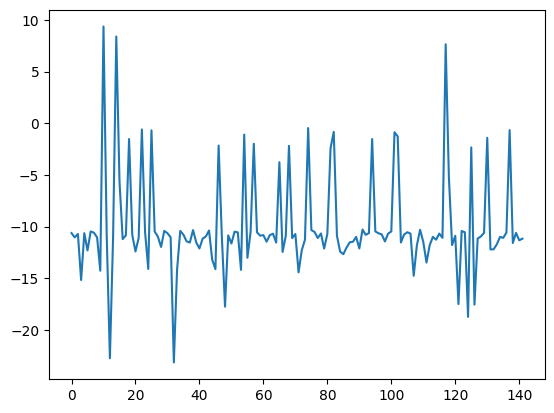

In [117]:
plt.plot(rewards)

In [107]:
def evaluate_snake_model(model, size=20, episodes=10, render=True):
    env = SnakeGame(size=size, render_mode="human" if render else None)
    model.eval()

    rewards = []

    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = model(state)
                action = torch.argmax(q_values, dim=1).item()

            obs, reward, done, _, _ = env.step(action)
            total_reward += reward

            if render:
                env.render()
    
        rewards.append(total_reward)
        print(f"Episode {episode + 1}: Reward = {total_reward}")

    env.close()
    avg_reward = sum(rewards) / episodes

    print(f"Average reward over {episodes} episodes: {avg_reward}")

In [108]:
evaluate_snake_model(snake_policy_net, 10)

Episode 1: Reward = -4.740000000000002
Episode 2: Reward = -126.25
Episode 3: Reward = -0.41999999999999993
Episode 4: Reward = -125.76000000000002


KeyboardInterrupt: 

In [ ]:
class ChaseEscapeEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, render_mode=None):
        super().__init__()

        self.dt = 0.1
        self.max_speed = 0.4
        self.agent_radius = 0.05
        self.target_radius = 0.05
        self.chaser_radius = 0.07
        self.chaser_speed = 0.03

        self.action_space = gym.spaces.MultiDiscrete([3, 3])  # actions in {0,1,2} map to [-1,0,1]
        self.observation_space = gym.spaces.Box(
            low=-1,
            high=1,
            shape=(8,),
            dtype=np.float32,
        )

        self.render_mode = render_mode
        self.screen_size = 500
        self.np_random = None

        if render_mode == "human":
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_size, self.screen_size))
            self.clock = pygame.time.Clock()

    def sample_pos(self, far_from=None, min_dist=0.5):
        while True:
            pos = self.np_random.uniform(low=-0.8, high=0.8, size=(2,))
            if far_from is None or np.linalg.norm(pos - far_from) >= min_dist:
                return pos

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.agent_pos = self.sample_pos()
        self.agent_vel = np.zeros(2, dtype=np.float32)
        self.target_pos = self.sample_pos(far_from=self.agent_pos, min_dist=0.5)
        self.chaser_pos = self.sample_pos(far_from=self.agent_pos, min_dist=0.7)

        return self._get_obs(), {}

    def _get_obs(self):
        # TODO: Decide how to pass the state (don't use pixel values)
        pass

    def _get_info(self):
        return {}

    def step(self, action):
        # TODO: Add reward scheme
        # 1) Try to make the agent stay within bounds
        # 2) The agent shouldn't idle around
        # 3) The agent should go for the reward
        # 4) The agent should avoid the chaser

        accel = (np.array(action) - 1) * 0.1
        self.agent_vel += accel
        self.agent_vel = np.clip(self.agent_vel, -self.max_speed, self.max_speed)
        self.agent_pos += self.agent_vel * self.dt
        self.agent_pos = np.clip(self.agent_pos, -1, 1)

        direction = self.agent_pos - self.chaser_pos
        norm = np.linalg.norm(direction)
        if norm > 1e-5:
            self.chaser_pos += self.chaser_speed * direction / norm

        dist_to_target = np.linalg.norm(self.agent_pos - self.target_pos)
        dist_to_chaser = np.linalg.norm(self.agent_pos - self.chaser_pos)

        reward = 0.0
        terminated = False

        if dist_to_target < self.agent_radius + self.target_radius:
            self.target_pos = self.sample_pos(far_from=self.agent_pos, min_dist=0.5)

        if dist_to_chaser < self.agent_radius + self.chaser_radius:
            terminated = True

        return self._get_obs(), reward, terminated, False, self._get_info()

    def render(self):
        if self.render_mode != "human":
            return

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.close()

        self.screen.fill((255, 255, 255))

        def to_screen(p):
            x = int((p[0] + 1) / 2 * self.screen_size)
            y = int((1 - (p[1] + 1) / 2) * self.screen_size)
            return x, y

        pygame.draw.circle(self.screen, (0, 255, 0), to_screen(self.target_pos), int(self.target_radius * self.screen_size))
        pygame.draw.circle(self.screen, (0, 0, 255), to_screen(self.agent_pos), int(self.agent_radius * self.screen_size))
        pygame.draw.circle(self.screen, (255, 0, 0), to_screen(self.chaser_pos), int(self.chaser_radius * self.screen_size))

        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])

    def close(self):
        if self.render_mode == "human":
            pygame.quit()


In [ ]:
# TODO: Train and evaluate CatMouseEnv